In [1]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [51]:
## convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1,dropnan=True, nskip = 1, skip=False):
    df = pd.DataFrame(data)
    cols, names = list(), list()

    #skip sequence (t + nskip, ... t + n)
    if skip:
        for j in range(n_vars):
            for i in np.arange(0, n_out, nskip):
                cols.append(df.iloc[:,j].shift(-i))
                names += [('{}{}(t+{})'.format(df.columns[0], j+1, i))]
    else:
        # input sequence (t-n, ... t-1)
        for j in range(n_vars):
            for i in range(n_in, 0, -1):
                cols.append(df.iloc[:,j].shift(i))
                names.append('{}{}(t-{})'.format(df.columns[0], j+1, i))

        # forecast sequence (t+1, ... t+n)
        for j in range(n_vars):
            for i in range(0, n_out):
                cols.append(df.iloc[:,j].shift(-i))
                names += [('{}{}(t+{})'.format(df.columns[0], j+1, i))]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## plot dataframe creation
def plot_df(arr, name):
    plot_df = pd.DataFrame()
    i = 0
    for row in arr:
        plot_df.insert(i, "{}".format(name), row, True) 
        i += 1
    return plot_df

def get_eval(y, yhat):
    print("MSE: {}".format(mean_squared_error(y,yhat)))
    print("MAE: {}".format(mean_absolute_error(y,yhat)))
    print("r2_score: {}".format(r2_score(y,yhat, multioutput = "variance_weighted")))
    
## feature/ target construction fucntion with lag variable
def feature_target_construct(df, load_lag, target_ahead, temp_ahead, tskip = 0, wd_on = False):
    tempcols = ['temperature']
    load = df['energy']
    f_temp = pd.DataFrame()
    for col in tempcols:
        if(tskip != 0):
            temp = lag_ahead_series(df[col], 
                                 n_in = 0,
                                 n_out = temp_ahead + 1,
                                 n_vars = 1,
                                 dropnan = True,
                                 nskip= tskip,
                                 skip = True)
        else:
             temp = lag_ahead_series(df[col], 
                                 n_in = 0,
                                 n_out = temp_ahead + 1,
                                 n_vars = 1,
                                 dropnan = True)
        f_temp = pd.concat([f_temp, temp], axis = 1)
    
    t = lag_ahead_series(load,
                          n_in = 0,
                          n_out = target_ahead + 1,
                          n_vars = 1,
                          dropnan = True)
                  
    if(target_ahead > temp_ahead):
        num_ahead = target_ahead
        f_temp = f_temp.iloc[load_lag:-num_ahead + temp_ahead,:]
        t = t.iloc[load_lag:,:]
    elif(target_ahead < temp_ahead):
        num_ahead = temp_ahead
        f_temp = f_temp.iloc[load_lag:,:]
        t = t.iloc[load_lag:-num_ahead + target_ahead,:]
    else:
        num_ahead = temp_ahead
        f_temp = f_temp.iloc[load_lag:,:]
        t = t.iloc[load_lag:,:]
        
    ## load lag series
    f_load = lag_ahead_series(load,
                          n_in = load_lag,
                          n_out = 0,
                          n_vars = 1,
                          dropnan = True).iloc[:-num_ahead,:]
    
    ## feature concatanation
    if wd_on:
        weekday = pd.get_dummies(df.iloc[load_lag:-num_ahead,-1])
        f = pd.concat([weekday, f_temp, f_load], axis = 1)
    else:
        f = pd.concat([f_temp, f_load], axis = 1)
    if('LCLid' in df.columns):
        f = pd.concat([f, df['LCLid'].iloc[load_lag:-num_ahead]],axis = 1)
    
    
    return f, t

In [5]:
train = pd.read_csv("../data/train_s_hh.csv",index_col = 'tstp')
test = pd.read_csv("../data/test_s_hh.csv", index_col = 'tstp')

### Creat lag ahead scenarios

In [52]:
ftrain, ttrain = feature_target_construct(train, 48, 48, 48, 6, True)
ftest, ttest = feature_target_construct(test, 48, 48, 48, 6, True)

In [ ]:
from tpot import TPOTRegressor
from tpot_mulr import mul_reg_config_dict
from sklearn.model_selection import TimeSeriesSplit
#import mul_config as mc

tpot_reg = TPOTRegressor(generations=10, population_size=50,
                         offspring_size=None, mutation_rate=0.9,
                         crossover_rate=0.1,
                         scoring='neg_mean_squared_error', 
                         cv= TimeSeriesSplit(n_splits = 10),
                         subsample=0.1, 
                         n_jobs=4,
                         max_time_mins=60, max_eval_time_mins=20,
                         random_state=1, 
                         config_dict=mul_reg_config_dict,
                         template=None,
                         warm_start=True,
                         memory=None,
                         use_dask=False,
                         periodic_checkpoint_folder=None,
                         early_stop=None,
                         verbosity=2,
                         disable_update_check=False)
tpot_reg.fit(ftrain, ttrain)

In [17]:
yhat = tpot_reg.predict(ftest)

In [18]:
get_eval(ttest.iloc[:1,:49].to_numpy().reshape(-1,1), yhat[:1,:49].reshape(-1,1))

MSE: 0.18772000209126094
MAE: 0.28996366939795915
r2_score: 0.26372216136933413


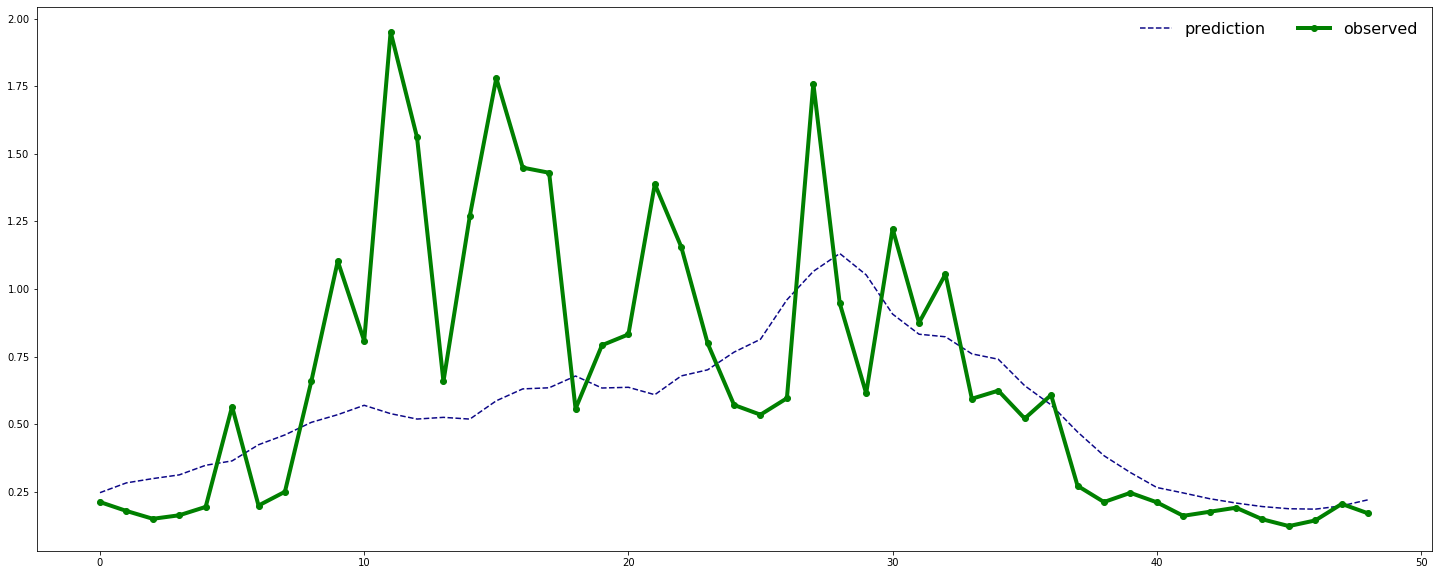

In [19]:
## assignment
real = ttest.to_numpy()
guess = yhat
real = real[0:1,:49]
guess = guess[0:1,:49]
rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()